In [83]:
import pandas as pd
import numpy as np
import re
import pickle
import seaborn as sb

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder

import xgboost
import optuna

import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
nltk.download('punkt_tab');
nltk.download('averaged_perceptron_tagger_eng');
nltk.download('wordnet');

# Klasifikacija vina na osnovu senzotnih opisa

U prethodnom poglavlju pokazali smo kako se vino može klasifikovati na crno i belo na osnovu fizičko-hemijskih karakteristika. 

Kako je u realnosti malo verovatno da su nam poznati ti podaci, ali ne i da li je vino crno ili belo, posmatramo malo drugačiji problem: klasifikacija stila vina na osnovu senzornih opisa.

**Senzorni opis** podrazumeva miris, ukus, teksturu, pitkost i slične opise koje možemo pronaći u recenzijama vina.

Kako nisu sva crna ni sva bela vina ista, potrebna nam je sitnija podela na **stilove vina**:

- *Champagne & Sparkling Wines* 
- *Light-Bodied White Wines*    
- *Aromatic White Wines*
- *Full-Bodied White Wines*
- *Rosé Wines*
- *Light-Bodied Red Wines*
- *Medium-Bodied Red Wines*
- *Full-Bodied Red Wines*
- *Dessert & Fortified Wines*
 
Više o pojedinačnim stilovima vina na https://winefolly.com/tips/the-9-major-wine-styles/.

Za potrebe ovog projekta koristili smo skup podataka sa recenzijama vina dostupan na https://www.kaggle.com/datasets/zynicide/wine-reviews. Sastoji se iz 130.000 recenzija i informacija o vinu i recenzentu i u svom izvornom obliku ne sadrži stil vina kao kolonu.

Projekat se sastoji iz tri dela:

1. Analiza skupa podataka - određivanje stila vina na osnovu imena i vrste grožđa
2. Priprema teksta - izdvajanje ključnih reči iz teksta recenzije i vektorizacija 
3. Klasifikacija - traženje optimalnog modela i ocena greške 

## Analiza skupa podataka

U izlazu sledeće ćelije možemo videti strukturu našeg skupa podataka. Kolone koje će nama biti od značaja su:
- `description` - tekst recenzije, do 135 reči 
- `title` - naziv vina
- `variety` -  vrsta grožđa od kojeg je vino napravljeno, 707 različih vrednosti

In [85]:
df = pd.read_csv("winemag-data-130k-v2.csv")
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [86]:
len(df['title'].unique())

118840

medijalna dužina: 39.0, opseg: [3, 135]


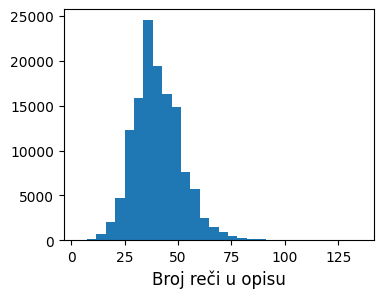

In [87]:
word_counts = [len(text.split()) for text in df['description']]
print(f"medijalna dužina: {np.median(word_counts)}, opseg: [{np.min(word_counts)}, {np.max(word_counts)}]")

plt.figure(figsize=(4, 3))
plt.hist(word_counts, bins=30)
plt.xlabel('Broj reči u opisu', fontsize=12)
plt.show()

In [88]:
df['variety'].value_counts()

variety
Pinot Noir                    13272
Chardonnay                    11753
Cabernet Sauvignon             9472
Red Blend                      8946
Bordeaux-style Red Blend       6915
                              ...  
Cabernet Sauvignon-Barbera        1
Sauvignonasse                     1
Forcallà                          1
Meseguera                         1
Bobal-Cabernet Sauvignon          1
Name: count, Length: 707, dtype: int64

## Određivanje stila

Kako u skupu postoji 707 vrsti grozda, želimo da ih grupišemo u 9 pomenutih kategorija.

Umesto domenskog znanja, za to je korišćen gpt-4o-mini i rezultati su upisani u `wine_variety_style.csv`. 
Za vina koja su obeležena kao mešavina vrsta ("Red Blend", "White Blend") nije bilo moguće odrediti tačnu kategoriju na ovaj nacin, zbog čega je za njih na isti način tražena kategorija direktno po imenu, i upisana u `wine_title_style.csv`. Za upite korišćena je skripta `get_wine_styles.py`

Bilo je potrebno ispitati 707 vrsti grozda i 10k pojedinačnih vina, čime smo dobili informafcije o kategoriji za svih 130k vina.

Iako nemamo način da utvrdimo tačnost ovakve klasifikacije, na primeru vina iz Srbije vidimo da deluje korektno. Model se oslanja na podatke sa interneta koji sami za sebe već nisu uvek tačni što je šum na koji ne možemo da utičemo (https://www.vivino.com/US/en/budimir-svb-rosa/w/1970828).

In [89]:
wine_variety_style = pd.read_csv('wine_variety_style.csv')
wine_title_style = pd.read_csv('wine_title_style.csv')
print(wine_variety_style['style'].value_counts())

style
Full-Bodied Red Wines          187
Light-Bodied White Wines       163
Aromatic White Wines           152
Medium-Bodied Red Wines        105
Light-Bodied Red Wines          45
Full-Bodied White Wines         24
Dessert & Fortified Wines       17
Champagne & Sparkling Wines      5
Rosé Wines                       4
Name: count, dtype: int64


In [90]:
df['title'] = (df['title'].str.replace('  ', ' ', regex=False).str.replace(r'\s\(.*(\(.*\))?\)', '', regex=True).str.strip())  
df_merged = pd.merge(df, wine_variety_style, how='left', left_on='variety', right_on='variety')
df_merged = pd.merge(df_merged, wine_title_style, how='left', left_on='title', right_on='wine_name')
df_merged['style'] = df_merged['style_x'].fillna(df_merged['style_y'])
# df_merged.info()

In [91]:
df_merged[df_merged['country'] == 'Serbia'][['title','variety','style']]

,title,variety,style
5090,Milijan Jelić 2011 Morava,Morava,Light-Bodied White Wines
22421,Agrina 2012 Portuguiser Blauer Portugieser,Blauer Portugieser,Light-Bodied Red Wines
29311,Budimir 2009 Sub Rosa Red,Red Blend,Medium-Bodied Red Wines
38555,Budimir 2009 Margus Margi Riesling,Riesling,Aromatic White Wines
38961,Budimir 2013 Župska Tamjanika,Tamjanika,Aromatic White Wines
51832,Agrina 2014 Portuguiser,Portuguiser,Light-Bodied Red Wines
64406,Budimir 2009 Sub Rosa Red,Red Blend,Medium-Bodied Red Wines
70991,Budimir 2007 Svb Rosa Red,Red Blend,Rosé Wines
72905,Budimir 2008 Margus Margi Riesling,Riesling,Aromatic White Wines
108175,Agrina 2014 Portuguiser,Portuguiser,Light-Bodied Red Wines


In [560]:
df = df_merged.dropna(subset=['style'])
# df.info()

In [561]:
df['style'].value_counts()

style
Full-Bodied Red Wines          47883
Aromatic White Wines           17556
Medium-Bodied Red Wines        15920
Light-Bodied Red Wines         14971
Full-Bodied White Wines        14572
Light-Bodied White Wines        9630
Champagne & Sparkling Wines     4604
Rosé Wines                      3785
Dessert & Fortified Wines       1098
Name: count, dtype: int64

## Izdvajanje ključnih reči recenzije

Recenzije vina su kratke i detaljne i opisuju njegov subjektivni osećaj. Konstrukcije rečenica su jednostavne i ne zavise mnogo od redosleda reči, što nam govori da je dovoljno da posmatramo samo pojedinačne reči koje se u komentaru nalaze. Takođe uklanjamo sve reči koje se nalaze u imenima vrsti vina, kako te reči ne bi uticale na klasifikaciju.

Na primeru vidimo opis koji sadrži reči "ripe", "smooth", "tannin", "berry", koje mogu da nas asociraju na jako crno vino, a teško bi se našle u opisu penušavog vina.

U opisu su ključne imenice, pridevi i glagoli, zbog čega ćemo ukloniti sve ostale vrste reči.

Na ovaj način su obrađene sve recenzije iz skupa, i sačuvane u `x_clean.pkl` radi lakšeg pokretanja.

In [562]:
X = df['description']  
y = df['style']
print(X[1])
print(y[1])

This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.
Full-Bodied Red Wines


In [584]:
wine_variant_words = df['variety'][df['variety'].notnull()].str.lower().str.split().values
unique_wine_words = set([word for sublist in wine_variant_words for word in sublist])
unique_wine_words.add('wine')
print(unique_wine_words)

{'sauvignonasse', 'malbec-tempranillo', 'papaskarasi', 'nebbiolo', 'pinot-chardonnay', 'franc-cabernet', 'mansois', 'ottonel', 'mavrodaphne', 'ondenc', 'vermentino', 'g-s-m', 'jacquère', 'arinto', 'rkatsiteli', 'sirica', 'chelois', 'sousão', 'malvasia-viura', 'charbono', 'merlot-syrah', 'blanc-semillon', 'carmenère', 'altesse', 'gris-gewürztraminer', 'marquette', 'servadou', 'macabeo-chardonnay', 'müller-thurgau', 'grigio-sauvignon', 'lambrusco', 'franc-merlot', 'duras', 'mencía', 'albarossa', 'manseng', 'baco', 'nacional-cabernet', 'garnacha-tempranillo', 'negra', 'noto', 'zelen', 'rosé', 'franca', 'franconia', 'piquepoul', 'cercial', 'airen', 'vidal', 'bobal', 'alfrocheiro', 'sauvignon-syrah', 'tannat', 'inzolia', 'madeleine', 'aleatico', 'prosecco', 'grenache', 'bombino', 'shiraz-malbec', 'canaiolo', 'courbu', 'neagra', 'picolit', 'refosco', 'loureiro-arinto', 'muskateller', 'apple', 'maturana', 'negro', 'mantonico', 'chancellor', 'ximénez', 'rolle', 'prié', 'roviello', 'aragonez', 

In [585]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def clean_text(text):
    text = text.lower()
    text = ''.join(char if char.isalpha() else ' ' for char in text)
    
    pos_tagged = pos_tag(text.split())
    text = [word for word, tag in pos_tagged if tag[0] in {'J', 'N', 'V'} and word not in stop_words and word not in unique_wine_words]
    
    text = [lemmatizer.lemmatize(word) for word in text]
    
    return " ".join(text)

In [586]:
clean_text(X[1])

'ripe fruity smooth structured firm tannin filled juicy berry fruit freshened acidity drinkable better'

In [587]:
# X = X.apply(clean_text)
# with open("x_clean.pkl", "wb") as file:
#     pickle.dump(X, file)
with open("x_clean.pkl", "rb") as file:
    X = pickle.load(file)

In [588]:
X.head()

0    aroma include tropical fruit broom brimstone d...
1    ripe fruity smooth structured firm tannin fill...
2    tart snappy flavor lime flesh rind dominate gr...
3    pineapple rind lemon pith blossom start aroma ...
4    much regular bottling come rough tannic rustic...
Name: description, dtype: object

### Podela i vektorizacija

Za izdvajanje kljičnih reči nismo primenili nikakvo specifično znanje koje bi bilo vezano za skup podataka. Sada je potrebno izdvojiti skup za testiranje kako bismo imali primere koji nisu uticali na dalji proces.

Na početku ćemo podeliti podatke samo na skup za obučavanje i testiranje, dok ćemo skup za validaciju izdvojiti kasnije iz skupa za obučavanje i koristiti ga za evaluaciju modela.

Za vektorizaciju teksta koristimo **TF-IDF** (*Term Frequency - Inverse Document Frequency*) : 
$$
TF\text{-}IDF = TF \cdot IDF
$$
$$
TF = \frac{\text{Broj pojavljivanja reči u dokumentu}}{\text{Ukupan broj reči u dokumentu}}
$$

$$
IDF = \log\left(\frac{\text{Ukupan broj dokumenata}}{\text{Broj dokumenata koji sadrže tu reč}}\right)
$$

**IDF** je tu da smanji težinu reči koje se pojavljuju u mnogim tekstovima, i samim tim nose malo informacije. 

Kako su se komentari sastoje od malo, ali pažljivo izabranih, reči, one se često neće ponavljati unutar jednog teksta, i samim tim će sve imati isti **TF**. To nam je ok.

Iako smo rekli da nas zanimaju reči koje se retko pojavljuju, i za to postoji granica. Reči koje se pojavljuju u tek ponekom primeru mogu dati lažnu sliku svog značenja (u našem primeru reč `lion` se pojavljuje samo jednom u odudarajućem komentaru 'Imported by Lion Nathan USA.' i nema nikakve veze sa tim što je vino stila Aromatic White Wines), dok sa druge strane nepotrebnu povećavaju dimenziju. Iz tih razloga, fokusnirani smo samo na reči koje se pojavljuju u barem 100 dokumenata (~0.1%)

In [589]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [590]:
tfidf_vectorizer = TfidfVectorizer(min_df=100) 

tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

print(len(tfidf_vectorizer.get_feature_names_out()))
print(tfidf_vectorizer.get_feature_names_out())

1976
['ability' 'abound' 'abrasive' ... 'zing' 'zingy' 'zippy']


## Klasifikacija

Poredimo dva pristupa:
- Naivni Bajesov klasifikator
- Nasumične šume (sa i bez gradijentnog pojačivanja)

Kako bismo mogli da izaberemo optimalan model, potrebno da iz skupa podataka za obučavanje izdvojimo skup za validaciju. Klase nisu jednako reprezentovane, ali nam je to u redu jer ni u stavrnosti nisu jednako verovatne.

Diskutabilno je koje je najbolja metrika za poređenje ovih modela, jer to zavisi od toga da li nam je bitnija opšta tačnost modela ili da svaku klasu što bolje razlikuje od ostalih. Iz tog razloga ćemo za svaki model posmatrati više metrika i matricu konfuzije, što ispisujemo funkcijom `print_report`.

Takođe se postavlja pitanje da li su nam sve greške jednako problematične - da li je isto ako model zameni jako crno vino za srednje jako, ili za penušavo. Iz tog razloga dodatno ispisujemo statistike grupisanih klasa funkcijom `print_grouped_report`. Ovde se posmatra odnos crnih, belih i rozé vina, dok se desertna zanemaruju. Desertna vina su posebno problematična jer pored toga što ih ima malo (~8%), imaju veći diverzitet. Mogu biti crna, bela, jača i slabija, što ih čini znatno težim za izolovanje. 

In [591]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(tfidf_train_vectors, y_train, test_size=0.2, random_state=42,stratify=y_train)

In [592]:
def print_report(true_values, pred_values, model):
    
    wine_style_order = [
    "Champagne & Sparkling Wines","Light-Bodied White Wines", "Aromatic White Wines", "Full-Bodied White Wines", 
    "Rosé Wines", "Light-Bodied Red Wines", "Medium-Bodied Red Wines", "Full-Bodied Red Wines", "Dessert & Fortified Wines"
    ]
    
    class_report = classification_report(true_values, pred_values, labels=wine_style_order)
    print(f"Classification report for {model}:\n\n", class_report)
    
    conf_matrix = confusion_matrix(true_values, pred_values, labels=wine_style_order)

    plt.figure(figsize=(5, 4))
    sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=wine_style_order, yticklabels=wine_style_order)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion matrix for {model}')
    plt.xticks(rotation=90)  
    plt.show()

In [593]:
def print_grouped_report(true_values, pred_values, model):
    grouped_wine_styles = {
        "white" : ["Champagne & Sparkling Wines","Light-Bodied White Wines", "Aromatic White Wines", "Full-Bodied White Wines"], 
        "red"   : ["Light-Bodied Red Wines", "Medium-Bodied Red Wines", "Full-Bodied Red Wines"],
        "rosé"  : ["Rosé Wines"],
        "desert": ["Dessert & Fortified Wines"]
    }

    inverted_wine_styles = {wine: group for group, wines in grouped_wine_styles.items() for wine in wines}

    y_train_val_grouped = [inverted_wine_styles[style] for style in true_values]
    y_pred_grouped = [inverted_wine_styles[style] for style in pred_values]

    grouped_order = list(grouped_wine_styles.keys())[:3]

    class_report = classification_report(y_train_val_grouped, y_pred_grouped)
    print(f"Grouped classification report for {model}:\n\n", class_report)

    conf_matrix = confusion_matrix(y_train_val_grouped, y_pred_grouped, labels=grouped_order)

    plt.figure(figsize=(6, 5))
    sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=grouped_order, yticklabels=grouped_order)
    plt.title(f'Grouped confusion matrix for {model}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

### Naivni Bajesov klasifikator
Multinomijalni naivni bajesov klasifikator podrazumeva da atribut koji modelujemo ima multinomijalnu raspodelu. 

Iz Bajesove formule koja se koristi za ovaj model,  $P(S_k | r) = \frac{P(S_k) \cdot P(r | S_k)}{P(r)}$, vidimo da će vino sa recenzijom $r$ koje ima jednake verovatnoće $P(r | S_i)$ i $P(r | S_j)$ za dva različita stila $i$ i $j$ biti izabran onaj stil koji je inače više prisutan. 

Ovim se delimično može objasniti zašto su sve vrste vina češće zamenjene za jaka crna, nego za lagana, što vidimo u matrici konfuzije.

Iz matrica konfuzije, kao i grupne tačnosti, takođe možemo videti da model bolje predviđa da li je vino crno ili belo, nego koja je tačno vrsta belog ili crnog vina u pitanju.

In [594]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_train, y_train_train)
y_pred = nb_classifier.predict(X_train_val)

Classification report for Naive Bayes:

                              precision    recall  f1-score   support

Champagne & Sparkling Wines       0.78      0.48      0.59       736
   Light-Bodied White Wines       0.62      0.42      0.50      1541
       Aromatic White Wines       0.62      0.78      0.69      2809
    Full-Bodied White Wines       0.70      0.69      0.69      2332
                 Rosé Wines       0.76      0.47      0.58       606
     Light-Bodied Red Wines       0.83      0.47      0.60      2395
    Medium-Bodied Red Wines       0.54      0.20      0.29      2547
      Full-Bodied Red Wines       0.66      0.94      0.78      7661
  Dessert & Fortified Wines       0.92      0.07      0.13       176

                   accuracy                           0.67     20803
                  macro avg       0.71      0.50      0.54     20803
               weighted avg       0.67      0.67      0.64     20803



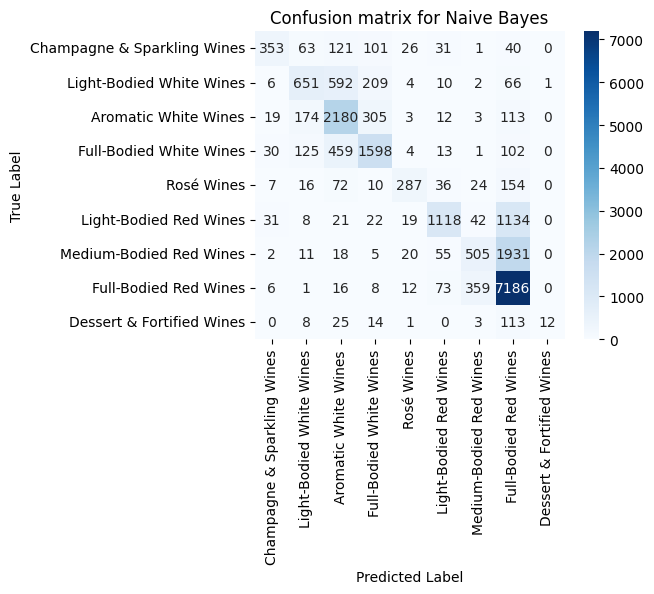

In [105]:
print_report(y_train_val, y_pred, "Naive Bayes")

Grouped classification report for Naive Bayes:

               precision    recall  f1-score   support

      desert       0.92      0.07      0.13       176
         red       0.94      0.98      0.96     12603
        rosé       0.76      0.47      0.58       606
       white       0.96      0.94      0.95      7418

    accuracy                           0.95     20803
   macro avg       0.90      0.62      0.66     20803
weighted avg       0.94      0.95      0.94     20803



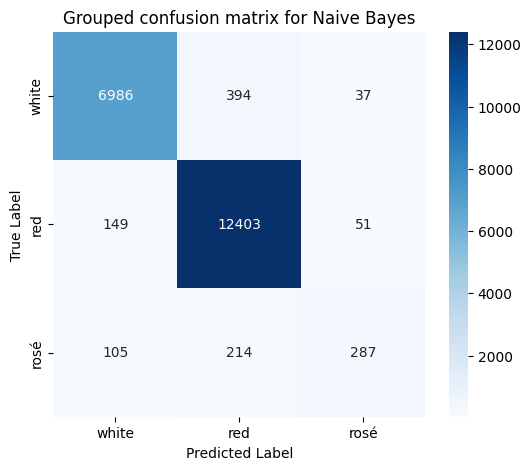

In [106]:
print_grouped_report(y_train_val,y_pred,"Naive Bayes")

#### Interpretacija modela
Iako naivni Bajesov klasifikator ima često slabije performanse od sofisticiranijih metoda, njegova velika prednost je interpretabilnost. Za svaki od stilova vina možemo saznati reči koje su za nju najrelevantnije:

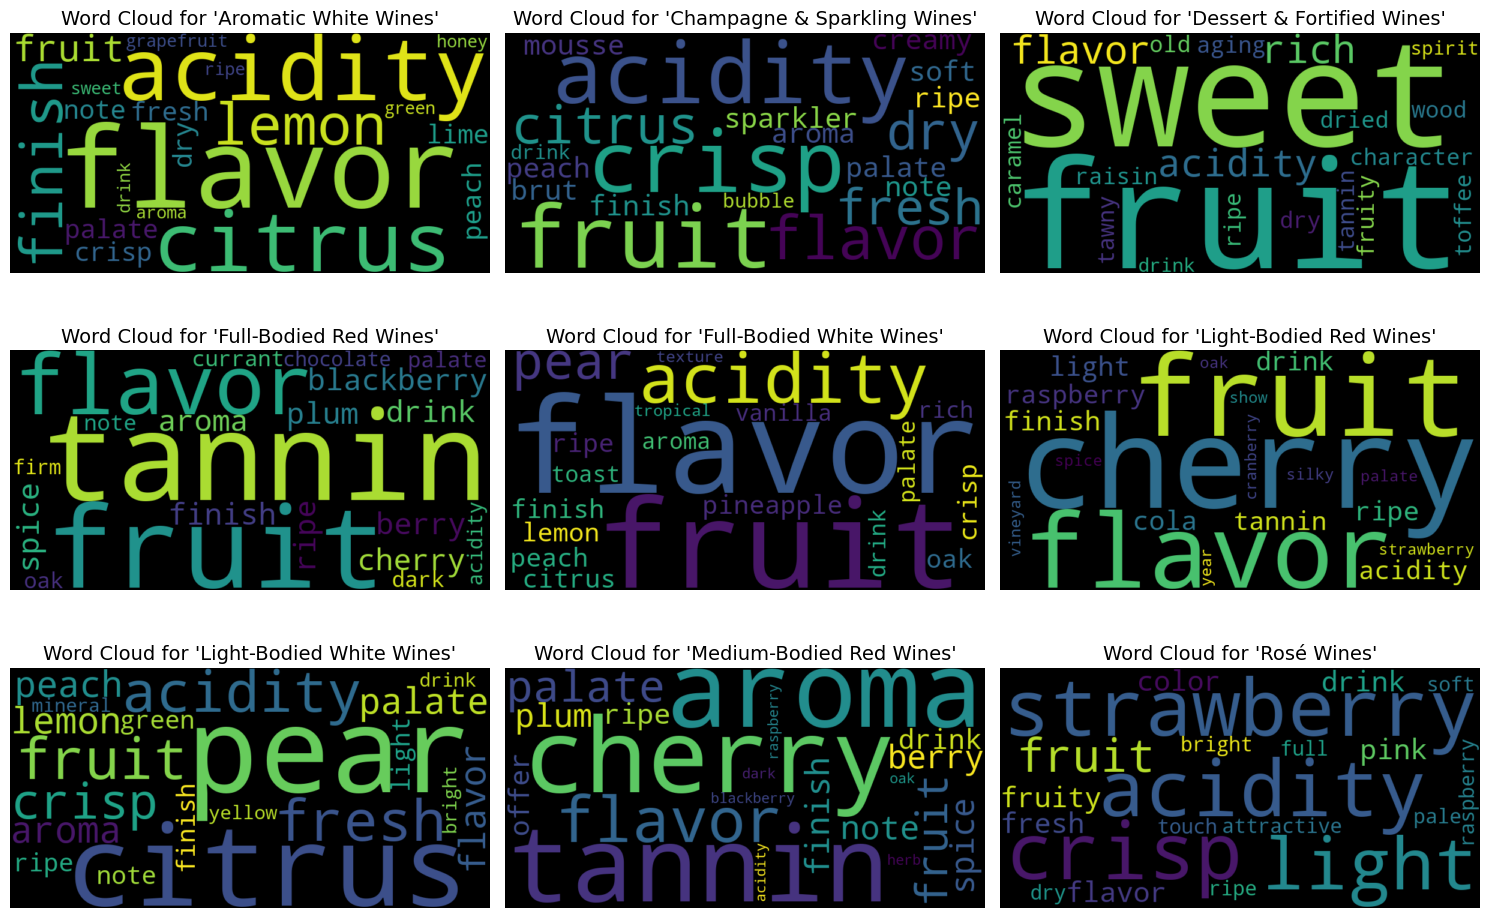

In [595]:
feature_names = tfidf_vectorizer.get_feature_names_out()
log_probabilities = nb_classifier.feature_log_prob_
log_prob_df = pd.DataFrame(log_probabilities, columns=feature_names, index=nb_classifier.classes_)

def generate_word_cloud(category, log_prob_df, num_words=20):
    top_words = log_prob_df.loc[category].sort_values(ascending=False).head(num_words)
    word_freq = {word: value for word, value in top_words.items() if word != 'wine'}
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq)
    return wordcloud


fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs = axs.flatten()

for i, category in enumerate(nb_classifier.classes_):
    wordcloud = generate_word_cloud(category, log_prob_df)
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis('off')
    axs[i].set_title(f"Word Cloud for '{category}'", fontsize=14)

for j in range(i + 1, 9):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

## Nasumična šuma

Drugi model koji koristimo za klasifikaciju je nasumična šuma. Iz rezultata vidimo da bolje izoluje konkretne vrste belih i vrste crnih vina, dok za grupisane stilove daje sličnu tačnost kao prethodni klasifikator.

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
rf_classifier.fit(X_train_train, y_train_train)
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)
with open('random_forest_model.pkl', 'rb') as f:
    rf_classifier = pickle.load(f)

y_pred_rf = rf_classifier.predict(X_train_val)

Classification report for Random Forest:

                              precision    recall  f1-score   support

Champagne & Sparkling Wines       0.80      0.51      0.62       736
   Light-Bodied White Wines       0.63      0.41      0.50      1541
       Aromatic White Wines       0.59      0.76      0.67      2809
    Full-Bodied White Wines       0.69      0.65      0.67      2332
                 Rosé Wines       0.67      0.46      0.55       606
     Light-Bodied Red Wines       0.74      0.51      0.61      2395
    Medium-Bodied Red Wines       0.76      0.19      0.30      2547
      Full-Bodied Red Wines       0.67      0.94      0.79      7661
  Dessert & Fortified Wines       0.88      0.20      0.32       176

                   accuracy                           0.67     20803
                  macro avg       0.71      0.51      0.56     20803
               weighted avg       0.68      0.67      0.64     20803



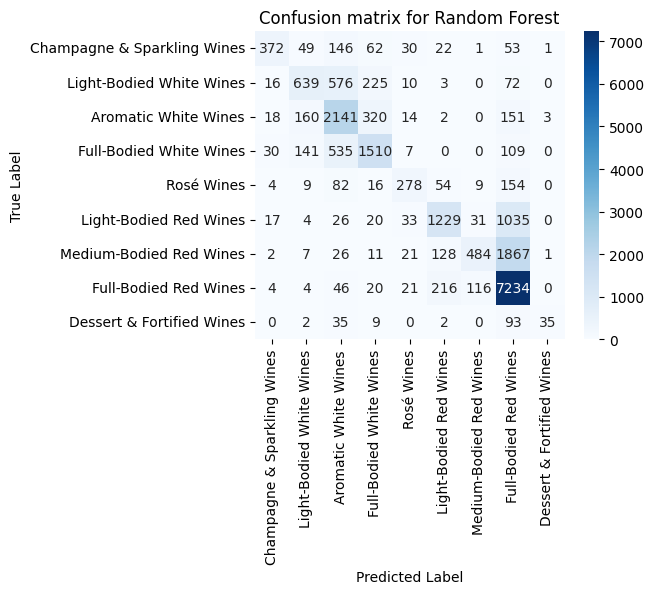

In [597]:
print_report(y_train_val, y_pred_rf, "Random Forest")

Grouped classification report for Random Forest:

               precision    recall  f1-score   support

      desert       0.88      0.20      0.32       176
         red       0.94      0.98      0.96     12603
        rosé       0.67      0.46      0.55       606
       white       0.95      0.94      0.94      7418

    accuracy                           0.94     20803
   macro avg       0.86      0.64      0.69     20803
weighted avg       0.94      0.94      0.94     20803



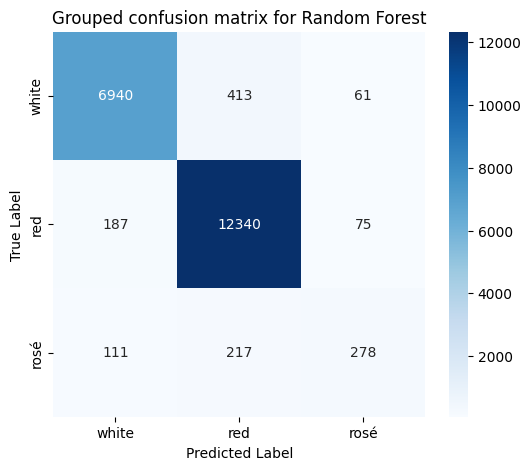

In [598]:
print_grouped_report(y_train_val, y_pred_rf, "Random Forest")

## XGBoost

XGBoost (eXtreme Gradient Boosting) koristi tehniku pojačavanja, gde se modeli grade sekvencijalno, pri čemu svako novo stablo ispravlja greške prethodnih. Ovaj pristup omogućava modelu da nauči iz grešaka i postane sve precizniji kroz iteracije.  

Kako bismo pronašli optimalne hiperparametre maksimalne dubine i broja stabala ansambla, koristimo paket `optuna`. Posebno ćemo ispitati optimalnu dubinu za fiksiran broj stabala, tražeći model koji ima minimalni težinski prosek f1 skora.

In [111]:
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train_train)
y_val_encoded = label_encoder.transform(y_train_val)  

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 10, 200)
    #n_estimators = trial.suggest_int('n_estimators', 100, 500)
    n_estimators = 100
    print(f"{trial.number = } : {max_depth = }, {n_estimators = }")

    model = xgboost.XGBClassifier(
        objective='multi:softmax', 
        n_estimators=n_estimators,  
        max_depth=max_depth,  
        random_state=42, 
        tree_method="hist",
        device="cuda"
    )

    model.fit(X_train_train, y_train_encoded)
    y_pred_val = model.predict(X_train_val)
    w_f1_score = f1_score(y_val_encoded, y_pred_val, average='weighted')
    print(f"{w_f1_score = :.4f}\n\n")

    return w_f1_score

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)
# with open('optuna_study.pkl', 'wb') as f:
#     pickle.dump(study, f)
with open('optuna_study.pkl', 'rb') as f:
    study = pickle.load(f)

print("Best hyperparameters found: ", study.best_params)
print("Best f1 score: ", study.best_value)

Best hyperparameters found:  {'max_depth': 72}
Best f1 score:  0.7512255491203347


In [599]:
import xgboost as xgb
from sklearn.metrics import f1_score

dtrain = xgb.DMatrix(X_train_train, label=y_train_encoded)
dval = xgb.DMatrix(X_train_val, label=y_val_encoded)

params = {
    'objective': 'multi:softmax',
    'num_class': len(set(y_train_encoded)),  
    'max_depth': 72,
    'tree_method': 'hist',
    'random_state': 42,
    'device': 'cuda',  
}

model_final = xgb.train(params, dtrain, num_boost_round=200)
# with open("xgb_model.pkl", "wb") as f:
#     pickle.dump(model_final, f)

with open("xgb_model.pkl", "rb") as f:
    model_final = pickle.load(f)

y_pred_val = model_final.predict(dval)
w_f1_score = f1_score(y_val_encoded, y_pred_val, average='weighted')
print(f"{w_f1_score = :.4f}")

w_f1_score = 0.6822


Classification report for XGBoost:

                              precision    recall  f1-score   support

Champagne & Sparkling Wines       0.76      0.59      0.67       736
   Light-Bodied White Wines       0.58      0.49      0.54      1541
       Aromatic White Wines       0.65      0.74      0.69      2809
    Full-Bodied White Wines       0.69      0.71      0.70      2332
                 Rosé Wines       0.69      0.56      0.62       606
     Light-Bodied Red Wines       0.74      0.63      0.68      2395
    Medium-Bodied Red Wines       0.60      0.32      0.41      2547
      Full-Bodied Red Wines       0.73      0.90      0.81      7661
  Dessert & Fortified Wines       0.70      0.25      0.37       176

                   accuracy                           0.70     20803
                  macro avg       0.68      0.58      0.61     20803
               weighted avg       0.69      0.70      0.68     20803



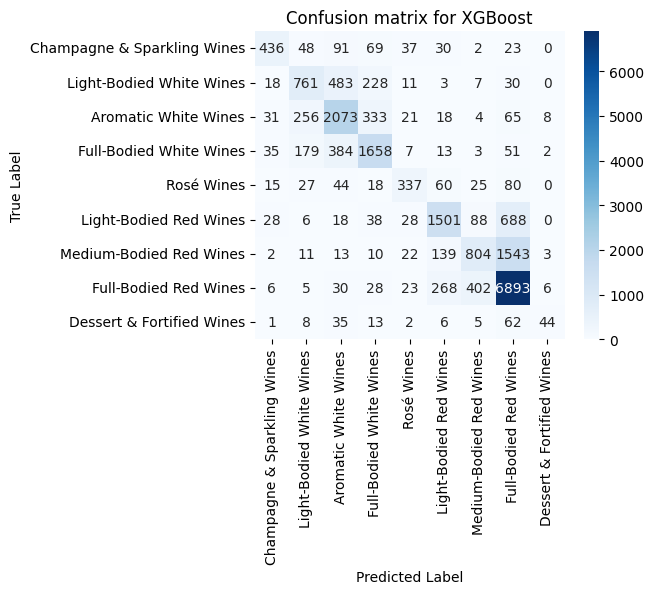

Grouped classification report for XGBoost:

               precision    recall  f1-score   support

      desert       0.70      0.25      0.37       176
         red       0.96      0.98      0.97     12603
        rosé       0.69      0.56      0.62       606
       white       0.95      0.95      0.95      7418

    accuracy                           0.95     20803
   macro avg       0.83      0.68      0.73     20803
weighted avg       0.95      0.95      0.95     20803



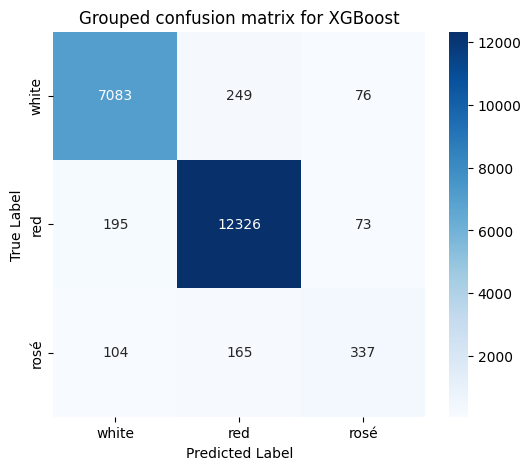

In [600]:
print_report(y_train_val, label_encoder.inverse_transform(y_pred_val.astype(int)), "XGBoost")
print_grouped_report(y_train_val, label_encoder.inverse_transform(y_pred_val.astype(int)), "XGBoost")

## Prilagođavanje modela 

Pomenuli smo problem nejednakih grešaka i da naš model to ne zna da razlikuje. Želimo i dalje da modelu bude prioritet da klase određuje tačno, ali da kada maši, ne maši mnogo. Za to je potrebno da na funkcije greške utiče podatak o tome koliko je predikcija "daleko" od stvarne vrednosti. Daljinu između klasa možemo definisati tako što preslikamo klase u neki prostor manje dimenzije i računamo euklidsko rastojanje na njemu.

### Određivanje reprezentacije na osnovu domenskog znanja

Jedan način da odredimo vektore reprezentacije klasa je na osnovu domenskog znanja. Klase slikamo u prostor dve dimenzije gde jedna predstavlja boju vina a druga jačinu:


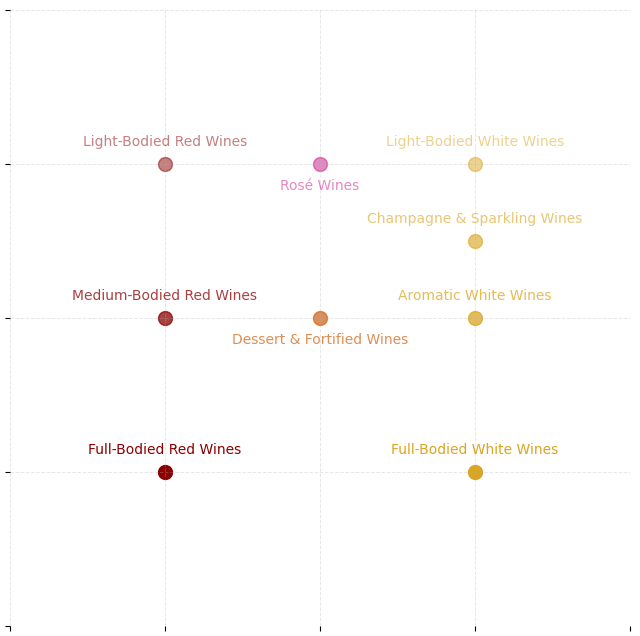

In [601]:
wine_positions ={
    "Champagne & Sparkling Wines": (1, 0.5, "white"),
    "Light-Bodied White Wines": (1, 1, "white"),
    "Aromatic White Wines": (1, 0, "white"),
    "Full-Bodied White Wines": (1, -1, "white"),
    "Rosé Wines": (0, 1, "rosé"),
    "Light-Bodied Red Wines": (-1, 1, "red"),
    "Medium-Bodied Red Wines": (-1, 0, "red"),
    "Full-Bodied Red Wines": (-1, -1, "red"),
    "Dessert & Fortified Wines": (0, 0, "desert")
}

wine_colors={
    "white": "goldenrod",
    "red": "darkred",
    "rosé": "mediumvioletred",
    "desert": "chocolate"
}


plt.figure(figsize=(8, 8))

for label, (x, y, wine_type) in wine_positions.items():
    alpha = 0.5 + (-y + 1) / 4
    color = wine_colors[wine_type]  
    
    if wine_type == "rosé" or wine_type == "desert":
        plt.text(x, y - 0.1, label, fontsize=10, ha='center', va='top', color=color, alpha=alpha)
    else:
        plt.text(x, y + 0.1, label, fontsize=10, ha='center', va='bottom', color=color, alpha=alpha)

    plt.scatter(x, y, s=100, color=color, alpha=alpha)

plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.3)
plt.xticks(range(-2, 3))
plt.yticks(range(-2, 3))
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()


### Određivanje reprezentacije unapred treniranim utapanjem

Drugi način bio bi korišćenjem utapanja (*text embeddings*) modelom koji je unapred trenirani tako da se slični vektori utapaju u bliske vektore. U primeru koristimo `text-embedding-3-small` za utapanje tekstova u prostor dimenzije 1536, a kasnije preslikavamo u 2, odnosno 3 dimenzije koristeći t-SNE (*t-distributed stochastic neighbor embedding*). 

t-SNE je statistička metoda za smanjenje dimenzionalnosti koja preslikava visoko-dimenzionalne podatke u prostor sa dve ili tri dimenzije. Slični objekti se modeluju bliskim tačkama, dok se različizi modeluju udaljenim tačkama sa velikom verovatnoćom.

Za svaki od 9 stilova vina nasumično je izabrano 100 instanci čiji se prosek smatra za reprezentaciju te klase.

Sa grafika vidimo da se vektori reprezentacija belih i crnih vina više razlikuju, nego vrste crnih vina međusobno, što je u skladu sa pređašnjim modelima.

In [692]:
n_samples_per_category = 100
unique_categories = np.unique(y_train)
np.random.seed(42)
indices = []

for category in unique_categories:
    category_indices = np.where(y_train == category)[0]
    selected_indices = np.random.choice(category_indices, n_samples_per_category, replace=False)
    indices.extend(selected_indices)  

In [693]:
np.min(indices), np.max(indices)

(72, 104005)

In [694]:
import openai
import os

# openai.api_key = os.getenv("OPENAI_API_KEY")
client = openai.OpenAI()

def get_embedding(text, model="text-embedding-3-small"):
    text = text.replace("\n", " ")
    return client.embeddings.create(input = [text], model=model).data[0].embedding

X_train_subset = X_train.iloc[indices] 
y_train_subset = y_train.iloc[indices]

# embeddings = np.array([get_embedding(text) for text in X_train_subset])
# with open("embeddings.pkl", "wb") as f:
#     pickle.dump(embeddings, f)
    
with open("embeddings.pkl", "rb") as f:
    embeddings = pickle.load(f)

In [856]:
from sklearn.manifold import TSNE

tsne_2d = TSNE(n_components=2, random_state=31)
embeddings_2d = tsne_2d.fit_transform(embeddings)

tsne_3d = TSNE(n_components=3, random_state=31)
embeddings_3d = tsne_3d.fit_transform(embeddings)

Aromatic White Wines [-3.0564706 -1.714138  16.092873 ]
Champagne & Sparkling Wines [-0.73010474 -4.6126647  12.009155  ]
Dessert & Fortified Wines [-3.884561   1.3285812 -6.9023423]
Full-Bodied Red Wines [  1.2830597   5.4632525 -20.474644 ]
Full-Bodied White Wines [-3.4171264  8.482435   7.28581  ]
Light-Bodied Red Wines [  1.3350875    0.03885745 -15.737851  ]
Light-Bodied White Wines [-5.0806246 -1.0197151 16.243675 ]
Medium-Bodied Red Wines [  7.158113   4.026492 -17.853941]
Rosé Wines [  4.6314178 -13.011418    2.4344969]


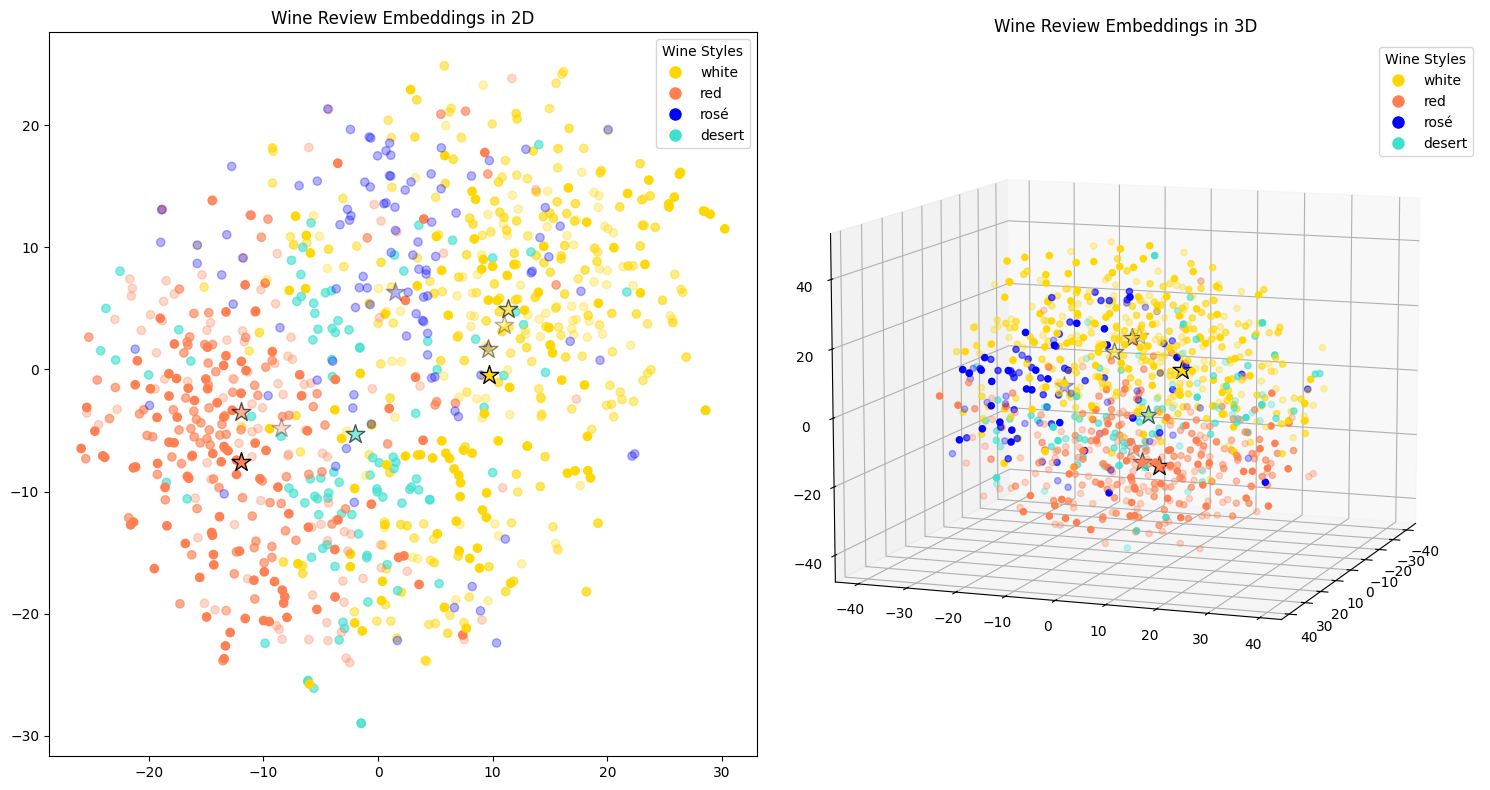

In [860]:
wine_styles = [wine_positions[category][2] for category in y_train_subset]
wine_alpha = [0.3 + (-wine_positions[category][1] + 1) / 3  for category in y_train_subset]
plot_colors = {'white': 'gold', 'red': 'coral', 'rosé': 'blue', 'desert': 'turquoise'}
colors = [plot_colors[style] for style in wine_styles]

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121)
scatter_2d = ax1.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=wine_alpha)
ax1.set_title('Wine Review Embeddings in 2D')

ax2 = fig.add_subplot(122, projection='3d')
scatter_3d = ax2.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=colors, alpha=wine_alpha)
ax2.set_title('Wine Review Embeddings in 3D')


categories = np.unique(y_train_subset)
means_3d = dict()
for category in categories:
    indices_ = np.where(np.array(y_train_subset) == category)[0]

    mean_2d = embeddings_2d[indices_].mean(axis=0)
    mean_3d = embeddings_3d[indices_].mean(axis=0)

    style = wine_positions[category][2]
    color = plot_colors[style]
    alpha = 0.3 + (-wine_positions[category][1] + 1) / 3

    ax1.scatter(mean_2d[0], mean_2d[1], c=color, marker='*', s=200, edgecolor='black', alpha=alpha)
    ax2.scatter(mean_3d[0], mean_3d[1], mean_3d[2], c=color, marker='*', s=200, edgecolor='black', alpha=alpha)
    print(category, mean_3d)
    means_3d[category] = mean_3d


unique_styles = list(plot_colors.keys())
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plot_colors[style], markersize=10) for style in unique_styles]

ax1.legend(handles=handles, labels=unique_styles, title='Wine Styles', loc='upper right')
ax2.legend(handles=handles, labels=unique_styles, title='Wine Styles', loc='upper right')
ax2.view_init(elev=10, azim=20)  
plt.tight_layout()
plt.show()


In [646]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(tfidf_train_vectors, y_train, test_size=0.2, random_state=42,stratify=y_train)

In [861]:
vectors = np.array(list(means_3d.values()))

magnitudes = np.linalg.norm(vectors, axis=1)
max_magnitude = np.max(magnitudes)
scale_factor = 1 / max_magnitude
scaled_vectors = vectors * scale_factor

scaled_means_3d = {key: scaled_vectors[i].tolist() for i, key in enumerate(means_3d)}

for wine, vector in scaled_means_3d.items():
    print(f"{wine}: {vector}")

Aromatic White Wines: [-0.1439707726240158, -0.08074207603931427, 0.7580322623252869]
Champagne & Sparkling Wines: [-0.034390565007925034, -0.21727313101291656, 0.5656744837760925]
Dessert & Fortified Wines: [-0.1829768270254135, 0.06258095800876617, -0.32512518763542175]
Full-Bodied Red Wines: [0.060436733067035675, 0.25733888149261475, -0.964429497718811]
Full-Bodied White Wines: [-0.16095896065235138, 0.3995532691478729, 0.3431878983974457]
Light-Bodied Red Wines: [0.06288743019104004, 0.0018303258111700416, -0.7413094639778137]
Light-Bodied White Wines: [-0.2393157184123993, -0.0480322539806366, 0.765135645866394]
Medium-Bodied Red Wines: [0.33717289566993713, 0.18966227769851685, -0.8409849405288696]
Rosé Wines: [0.21815645694732666, -0.6128847002983093, 0.11467356979846954]


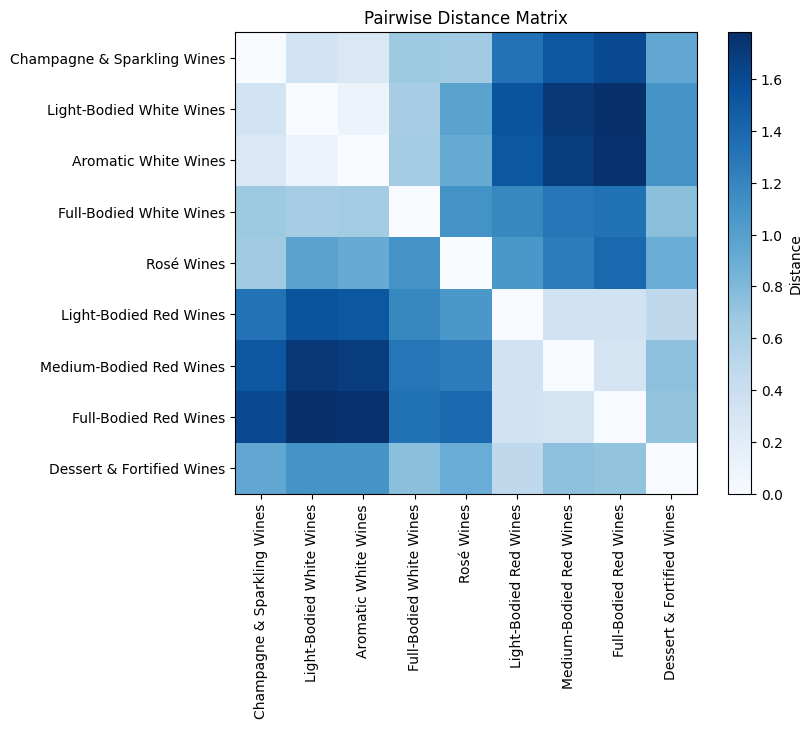

In [870]:
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

import matplotlib.pyplot as plt

wine_style_order = [
    "Champagne & Sparkling Wines","Light-Bodied White Wines", "Aromatic White Wines", "Full-Bodied White Wines", 
    "Rosé Wines", "Light-Bodied Red Wines", "Medium-Bodied Red Wines", "Full-Bodied Red Wines", "Dessert & Fortified Wines"
    ]

# Get the vectors from scaled_means_3d
vectors = np.array([scaled_means_3d[style] for style in wine_style_order])

dist_matrix = pairwise_distances(vectors)
plt.figure(figsize=(8, 6))
plt.imshow(dist_matrix, cmap='Blues')
plt.colorbar(label='Distance')
plt.title('Pairwise Distance Matrix')
plt.xticks(np.arange(len(scaled_means_3d)), wine_style_order, rotation=90)
plt.yticks(np.arange(len(scaled_means_3d)), wine_style_order)
plt.show()

### Funkcija greške

Koristimo unakrsnu entropiju tako što Euklidska rastojanja između predikovanih vektora i vektora reprezentacija klasa kao logite:

$$
f(\mathbf{y})_i = \frac{e^{-d(\mathbf{y}, \mathbf{v}_i)}}{\sum_{j \in S} e^{-d(\mathbf{\hat{y}}, \mathbf{v}_j)}}
$$
$$
L_{\text{s}} = - \sum_{i \in S}p(i) \cdot log(f(\mathbf{y})_i)
$$


Gde:
- $ d(\mathbf{\hat{y}}, \mathbf{y}_i) $ predstavlja Euklidsko rastojanje između predikovanog vektora $ \mathbf{\hat{y}} $ i vektora reprezentacije klase $i$, $ \mathbf{v}_i$
- $p$ - tačna raspodela, $p(i) = 1$ ako je $i$ tačna klasa, inače je 0.




In [874]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import scipy.sparse
import numpy as np
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if scipy.sparse.issparse(X_train_train):
    X_train_train = X_train_train.toarray()
if scipy.sparse.issparse(X_train_val):
    X_train_val = X_train_val.toarray()

y_train_c = np.array([scaled_means_3d[category] for category in y_train_train])
y_val_c = np.array([scaled_means_3d[category] for category in y_train_val])

y_train_train_tensor = torch.tensor(y_train_c, dtype=torch.float32).to(device)
y_train_val_tensor = torch.tensor(y_val_c, dtype=torch.float32).to(device)

X_train_train_tensor = torch.tensor(X_train_train, dtype=torch.float32).to(device)
X_train_val_tensor = torch.tensor(X_train_val, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_train_tensor, y_train_train_tensor)
val_dataset = TensorDataset(X_train_val_tensor, y_train_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = nn.Sequential(
    nn.Linear(X_train_train.shape[1], 512),  #X_train_train.shape[1] + 1967
    nn.ReLU(),                              
    nn.Linear(512, 128),                      
    nn.ReLU(),  
    nn.Linear(128, 32),                      
    nn.ReLU(),  
    nn.Linear(32, 8),                      
    nn.ReLU(),                            
    nn.Linear(8, 3)                        
).to(device)

means_3d_tensor = torch.tensor(np.array(list(scaled_means_3d.values())), dtype=torch.float32).to(device)

def hybrid_loss(outputs, labels, means_3d):
    distances = torch.cdist(outputs, means_3d_tensor)
    true_class_indices = torch.argmin(torch.cdist(labels, means_3d_tensor), dim=1)
    
    softmax_loss = F.cross_entropy(-distances, true_class_indices)
    return softmax_loss

optimizer = optim.Adam(model.parameters(), lr=0.001)

patience = 5
best_val_loss = float('inf')
patience_counter = 0

num_epochs = 100


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        
        # Use hybrid loss: mix of distance-based and softmax loss
        loss = hybrid_loss(outputs, batch_y, means_3d)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            val_outputs = model(batch_X)
            val_loss += hybrid_loss(val_outputs, batch_y, means_3d).item()

    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'wine_classification_model_best.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best validation loss: {best_val_loss:.4f}")
        break

torch.save(model.state_dict(), 'wine_classification_model.pth')



Epoch [1/100], Train Loss: 1.6494, Val Loss: 1.6135
Epoch [2/100], Train Loss: 1.5960, Val Loss: 1.6011
Epoch [3/100], Train Loss: 1.5765, Val Loss: 1.5946
Epoch [4/100], Train Loss: 1.5592, Val Loss: 1.5931
Epoch [5/100], Train Loss: 1.5442, Val Loss: 1.5916
Epoch [6/100], Train Loss: 1.5326, Val Loss: 1.5908
Epoch [7/100], Train Loss: 1.5229, Val Loss: 1.5916
Epoch [8/100], Train Loss: 1.5150, Val Loss: 1.5906
Epoch [9/100], Train Loss: 1.5077, Val Loss: 1.5885
Epoch [10/100], Train Loss: 1.5015, Val Loss: 1.5897
Epoch [11/100], Train Loss: 1.4974, Val Loss: 1.5942
Epoch [12/100], Train Loss: 1.4941, Val Loss: 1.5939
Epoch [13/100], Train Loss: 1.4917, Val Loss: 1.5929
Epoch [14/100], Train Loss: 1.4894, Val Loss: 1.5931
Early stopping at epoch 14. Best validation loss: 1.5885


Classification report for NN with custom loss function:

                              precision    recall  f1-score   support

Champagne & Sparkling Wines       0.59      0.59      0.59       736
   Light-Bodied White Wines       0.52      0.09      0.16      1541
       Aromatic White Wines       0.52      0.78      0.62      2809
    Full-Bodied White Wines       0.66      0.68      0.67      2332
                 Rosé Wines       0.68      0.51      0.58       606
     Light-Bodied Red Wines       0.65      0.63      0.64      2395
    Medium-Bodied Red Wines       0.49      0.26      0.34      2547
      Full-Bodied Red Wines       0.74      0.85      0.79      7661
  Dessert & Fortified Wines       0.20      0.23      0.21       176

                   accuracy                           0.64     20803
                  macro avg       0.56      0.51      0.51     20803
               weighted avg       0.63      0.64      0.62     20803



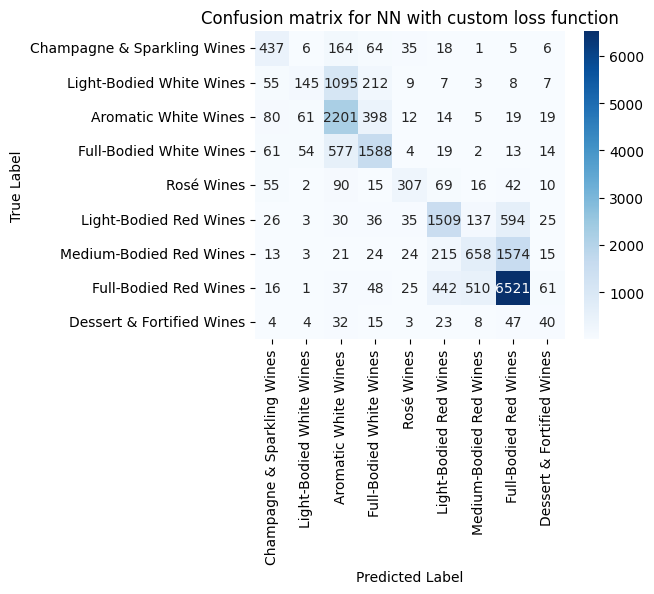

Grouped classification report for NN with custom loss function:

               precision    recall  f1-score   support

      desert       0.20      0.23      0.21       176
         red       0.97      0.96      0.97     12603
        rosé       0.68      0.51      0.58       606
       white       0.94      0.97      0.95      7418

    accuracy                           0.95     20803
   macro avg       0.70      0.67      0.68     20803
weighted avg       0.95      0.95      0.95     20803



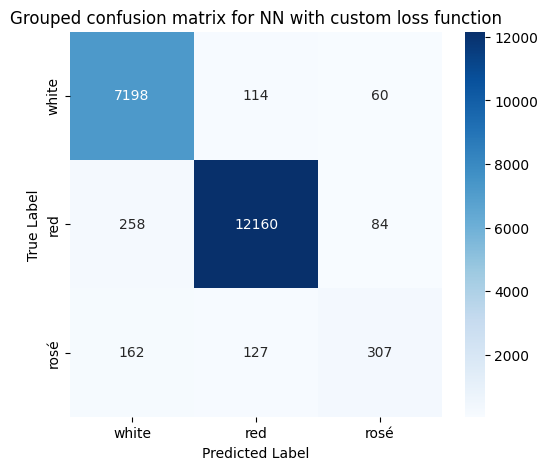

In [873]:
def generate_predictions(model, data_loader, means_3d):
    model.eval()
    all_preds = []
    all_true = []
    means_3d_tensor = torch.tensor(np.array(list(means_3d.values())), dtype=torch.float32).to(device)
    wine_names = list(means_3d.keys())
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)

            distances = torch.cdist(outputs, means_3d_tensor)
            predicted_indices = torch.argmin(distances, dim=1)  # Find the closest category

            predicted_wine_names = [wine_names[i] for i in predicted_indices.cpu().numpy()]
            all_preds.extend(predicted_wine_names)

            true_indices = [np.argmin(np.linalg.norm(means_3d_tensor.cpu().numpy() - y_true, axis=1)) for y_true in batch_y.cpu().numpy()]
            true_wine_names = [wine_names[i] for i in true_indices]
            all_true.extend(true_wine_names)
    
    return all_true, all_preds

true_values, pred_values = generate_predictions(model, val_loader, scaled_means_3d)

print_report(true_values, pred_values, "NN with custom loss function")
print_grouped_report(true_values, pred_values, "NN with custom loss function")

# Zaključak

Iako dobijeni model ima manju tačnost u određivanju konkretnih stilova vina, ima veću grupisanu tačnost nego naivni bajesov klasifikator i nasumična šuma, što sugeriše da su greške koje pravi manje. 

Ipak, najbolje rezultate daje nasumična šuma sa gradijentnim pojačavanjem.

## Ponovno obučavanje

w_f1_score = 0.6940
Classification report for XGBoost final:

                              precision    recall  f1-score   support

Champagne & Sparkling Wines       0.81      0.63      0.71       921
   Light-Bodied White Wines       0.61      0.52      0.56      1926
       Aromatic White Wines       0.67      0.74      0.70      3511
    Full-Bodied White Wines       0.69      0.72      0.70      2914
                 Rosé Wines       0.69      0.57      0.62       757
     Light-Bodied Red Wines       0.75      0.63      0.69      2994
    Medium-Bodied Red Wines       0.62      0.33      0.43      3184
      Full-Bodied Red Wines       0.74      0.91      0.81      9577
  Dessert & Fortified Wines       0.81      0.30      0.44       220

                   accuracy                           0.71     26004
                  macro avg       0.71      0.60      0.63     26004
               weighted avg       0.70      0.71      0.69     26004



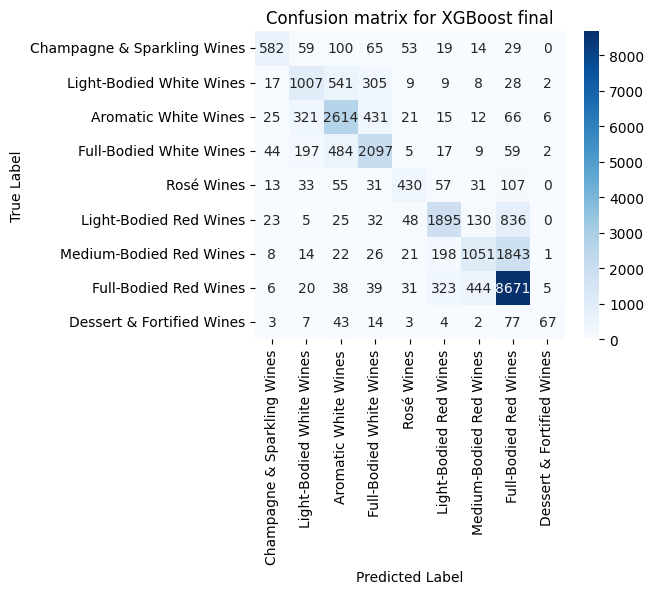

Grouped classification report for XGBoost final:

               precision    recall  f1-score   support

      desert       0.81      0.30      0.44       220
         red       0.96      0.98      0.97     15755
        rosé       0.69      0.57      0.62       757
       white       0.95      0.96      0.95      9272

    accuracy                           0.95     26004
   macro avg       0.85      0.70      0.75     26004
weighted avg       0.95      0.95      0.95     26004



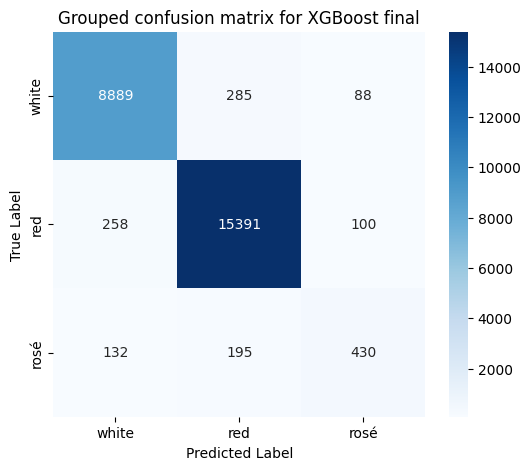

In [876]:
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test) 

dtrain = xgb.DMatrix(tfidf_train_vectors, label=y_train_encoded)
dval = xgb.DMatrix(tfidf_test_vectors, label=y_test_encoded)

params = {
    'objective': 'multi:softmax',
    'num_class': len(set(y_train_encoded)),  
    'max_depth': 72,
    'tree_method': 'hist',
    'random_state': 42,
    'device': 'cuda',  
}

model_final = xgb.train(params, dtrain, num_boost_round=200)
with open("xgb_model_final.pkl", "wb") as f:
    pickle.dump(model_final, f)

# with open("xgb_model.pkl", "rb") as f:
#     model_final = pickle.load(f)

y_pred_val = model_final.predict(dval)
w_f1_score = f1_score(y_test_encoded, y_pred_val, average='weighted')
print(f"{w_f1_score = :.4f}")

print_report(y_test, label_encoder.inverse_transform(y_pred_val.astype(int)), "XGBoost final")
print_grouped_report(y_test, label_encoder.inverse_transform(y_pred_val.astype(int)), "XGBoost final")